# CAP 378 Tópicos em Observação da Terra

Trabalho final: PAD (processamento de alto desempenho) em PDI

# Objetivo

O objetivo deste trabalho da disciplina CAP 378 é a avaliação de performance obtida em conversão de imagens utilizando Python e biblioteca MPI, em um ambiente de processamento paralelo.

# Introdução

PAD (Processamento de Alto Desempenho) pode ser definido como a prática de agregar capacidade de computação de tal forma a gerar um desempenho muito maior do que poderia ser obtido normalmente, e possui o objetivo de resolver grandes problemas em ciência, engenharia, ou negócios. PAD como conceito não está limitado a supercomputadores ou grandes sistemas, podendo ser aplicado inclusive a computadores comuns aonde se utilizam técnicas para aproveitar toda capacidade de processamento, obtendo-se grande performace.

## Processamento paralelo

Atualmente os principais sistemas computacionais de alto desempenho utilizam processadores comerciais e possuem arquitetura interligada para obter desempenho através da computação paralela. Simplificadamente são compostos por muitos processadores em paralelo trabalhando em conjunto. Programas de alto desempenho são feitos para dividir o processamento entre os vários processadores ou núcleos, executando ao mesmo tempo, de tal forma a aproveitar a capacidade de todos os processadores trabalhando juntos.

Podemos pensar em um programa rodando em vários núcleos de vários processadores, e em vários nós de computação.

![](img/Pentium4M740_fingers.jpg)
*Fonte: http://www.pcstats.com*

![](img/die.jpg)
*Fonte: https://images.anandtech.com*

Várias CPUs podem ser unidas, formando um Cluster:

![](img/1024px-Beowulf.png)
*Fonte: https://en.wikipedia.org*

## Supercomputador Santos Dumont (CAP 372/399)

https://sdumont.lncc.br

![](img/sdumont01.jpg)
*Fonte: tribunadepetropolis.com.br*

![](img/sdumont02.jpg)

![](img/sdumont03.jpg)

![](img/sdumont04.jpg)

Cada processador Intel Xeon E5-2695v2 Ivy Bridge possuim 12 núcleos x86.

Cada nó de computação possui 2 processadores e 24 núcleos x86.

No total são 756 nós com 18.144 núcleos x86.

Exemplo de um processador Xeon similar ao do Santos Dumont. Esse possui 18 núcleos:

![](img/zeon-z5-18core.jpeg)
*Fonte: www.overclock.net*

## Análise de desempenho

Outros conceitos que são inerentes ao PAD são o de medição e análise de desempenho para que se possa avaliar a performance computacional obtida, e o de identificação e quantificação de fatores que afetam a escalabilidade de computação paralela. A figura a seguir mostra um exemplo de análise de desempenho em um slide da disciplina CAP 399.

![](img/speedup399.png)
*Fonte: CAP399*

## Python

Python é um forte candidato para escrever as partes de alto nível de aplicações científicas que utilizam processamento de alto desempenho, pois agrega todos os benefícios de uma linguagem de script como rapidez e economia de desenvolvimento de código e manutenção, além de atuar como uma extensão, integrando bibliotecas escritas em outras linguagens compiladas em um único ambiente fácil de ser usado.

## Idéia do programa de conversão de imagens

A idéia original surgiu da discussão

https://gis.stackexchange.com/questions/15146/how-to-emulate-this-grayscale-basemap-lookfeel-in-google-maps

aonde existia a demanda para criação de basemaps em tons de cinza a partir de imagens coloridas, e com o tempo foi sendo alterada para agregar outras idéias relacionadas, em especial o processamento paralelo.

![](img/basemap.jpg)

# Descrição

## Download do dataset

GMapCather (https://github.com/heldersepu/GMapCatcher)

![](img/gmc1.jpg)

Serviço online Nokia Maps

![](img/gmc2.jpg)

Usando o GMapCather (escrito em Python) navegamos online, e as imagens (basemaps) são baixadas e gravadas em um diretório "map".

A próxima etapa é converter para um arquivo numpy "map01.npy":

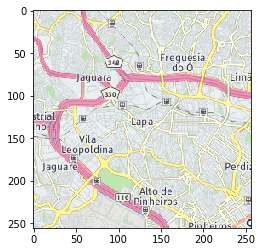

Elapsed time: 3.085407018661499 s


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
import glob
import time

def get_class(img_path):
    return int(img_path.split('/')[-2])

# main
time1 = time.time()
root_dir = 'map/tiles/'
imgs = []
all_img_paths = glob.glob(os.path.join(root_dir, '*/*/*/*/*.png'))
all_img_paths
for img_path in all_img_paths:
    img = io.imread(img_path)
    img = (img / 255.0)  # rescale (senão o n.array float dá mensagem de aviso)
#    img = transform.resize(img, (256, 256))
    imgs.append(img)
X = np.array(imgs, dtype='float32')
np.save("data/map01.npy",X)
plt.imshow(X[5, :, :, :].tolist())
plt.show()
print("Elapsed time:", time.time() - time1, "s" )

Execução serial usando uma função que pega um lote de imagens e converte para escala de cinza:

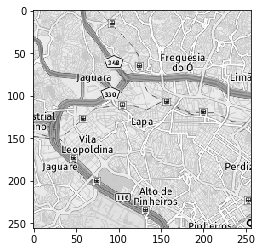

Elapsed time: 4.093225002288818 s


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import time

def grayscale_exposure_equalize(batch_X):
    """Processes a batch with images by grayscaling, normalization and histogram equalization.
    Args:
        batch_X: a single batch of data containing a numpy array of images.
    Returns:
        Numpy array of processed images.
    """
    X_processed_sub = np.zeros(batch_X.shape[:-1])
    for i in range(len(batch_X)):
        # Grayscale
        img_gray = np.dot(batch_X[i][...,:3], [0.299, 0.587, 0.114])
        # Normalization
        img_gray_norm = img_gray / (img_gray.max() + 1)
        X_processed_sub[i,...] = img_gray_norm
    return (X_processed_sub)

# main
time1 = time.time()
X = np.load("data/map01.npy")
X2 = grayscale_exposure_equalize(X)
np.save("data/map02.npy",X2)
plt.imshow(X2[5], cmap='gray')
plt.show()
print("Elapsed time:", time.time() - time1, "s" )

Quando o programa abaixo estiver pronto, ele irá dividir o processamento para execução paralela

In [ ]:
# Usage: mpiexec -n <NTASKS> python3 testempi.py

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
wt = MPI.Wtime()

# passing MPI datatypes explicitly
if rank == 0:
    data = numpy.arange(1000, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
    data = numpy.empty(1000, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)

# automatic MPI datatype discovery
if rank == 0:
    data = numpy.arange(100, dtype=numpy.float64)
    comm.Send(data, dest=1, tag=13)
elif rank == 1:
    data = numpy.empty(100, dtype=numpy.float64)
    comm.Recv(data, source=0, tag=13)

print('Elapsed time = ', MPI.Wtime() - wt, 's ,    Rank = ', rank)

In [ ]:
x@SAMS:~/Documents/1_INPE/378TOP$ mpiexec -n 2 python3 testempi.py 
Elapsed time =  0.00027294999995319813 s ,    Rank =  1
Elapsed time =  0.0002731700001277204 s ,    Rank =  0
x@SAMS:~/Documents/1_INPE/378TOP$ mpiexec -n 4 python3 testempi.py 
Elapsed time =  6.878999784021289e-06 s ,    Rank =  2
Elapsed time =  6.509000058940728e-06 s ,    Rank =  3
Elapsed time =  0.00036754199982169666 s ,    Rank =  0
Elapsed time =  0.0003176530001383071 s ,    Rank =  1
x@SAMS:~/Documents/1_INPE/378TOP$ mpiexec -n 3 python3 testempi.py 
Elapsed time =  6.99500014889054e-06 s ,    Rank =  2
Elapsed time =  0.000414257000102225 s ,    Rank =  0
Elapsed time =  0.020101229999909265 s ,    Rank =  1

# Ambiente de testes

## Cluster

Nó | Core | Thread | Processador | Instruções | Freq | Cache | RAM | GPU
:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|-
node01   | 2  | 4 | Core i7-7500U | avx2, fma3, sse4.2 | 3.5 GHz | 4 MB L3 | 16 GB | NVIDIA GeForce 940MX 4 GB
node02   | 4  | 8 | Core i7-2630QM | avx, sse4.2 | 2.6 GHz | 6 MB L3 | 8 GB
node03   | 4  | 8 | Core i7-2630QM | avx, sse4.2 | 2.6 GHz | 6 MB L3 | 6 GB
node04   | 2  | 2 | Core2Duo T7200 | ssse3 | 2 GHz | 4 MB L2 | 2 GB
node05   | 2  | 2 | Core2Duo T7200 | ssse3 | 2 GHz | 4 MB L2 | 2 GB
node06   | 2  | 2 | Core2Duo T7250 | ssse3 | 2 GHz | 2 MB L2 | 3 GB
node07   | 2  | 4 | Core i7-3520M | avx, sse4.2 | 3.6 GHz | 4 MB L3 | 8 GB | NVIDIA GeForce GT 635M 2 GB
SUBTOTAL | 18 | 30 | | | | |
master   | 1  | 2 | Atom N450 | ssse3 | 1.66 GHz | 512 kB L2 | 2 GB | (nó de login)

Os nós rodam Xubuntu 18.04.3 lts, e o switch é 10/100M ethernet

![*Fonte: ucdavis-bioinformatics-training.github.io*](img/cluster_diagram.png)

Aspecto físico

![](img/cluster_20191120_125327b.jpg)

# Resultados obtidos

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed ex purus, finibus at tortor et, vehicula mollis ipsum. Nullam eu elementum tortor. Fusce consequat porttitor rhoncus. Pellentesque sapien dui, hendrerit eu volutpat sed, mattis id sapien. Praesent feugiat convallis mattis. In pharetra mi ut interdum pharetra. Donec semper quis ante non blandit.

![](img/speedup399.png)

Mauris maximus mauris a quam gravida imperdiet. Curabitur bibendum diam elit, convallis aliquam mi tristique ut. Donec a tortor justo. Integer interdum auctor erat, non elementum purus porttitor eget. Quisque vel dui elementum, vestibulum tortor porta, condimentum turpis. Aenean accumsan cursus ex, fringilla maximus lacus. Aliquam convallis eros sed diam consectetur, fermentum tincidunt metus faucibus. Aliquam erat volutpat. Nunc sagittis justo dapibus ex ornare mollis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Praesent euismod pulvinar tellus, iaculis tempor dolor euismod a. Interdum et malesuada fames ac ante ipsum primis in faucibus. Cras fringilla faucibus ligula vitae pulvinar. Donec non tincidunt felis. Suspendisse convallis leo velit, vel lobortis orci efficitur sed. 

# Discussão dos resultados

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed ex purus, finibus at tortor et, vehicula mollis ipsum. Nullam eu elementum tortor. Fusce consequat porttitor rhoncus. Pellentesque sapien dui, hendrerit eu volutpat sed, mattis id sapien. Praesent feugiat convallis mattis. In pharetra mi ut interdum pharetra. Donec semper quis ante non blandit.

Mauris maximus mauris a quam gravida imperdiet. Curabitur bibendum diam elit, convallis aliquam mi tristique ut. Donec a tortor justo. Integer interdum auctor erat, non elementum purus porttitor eget. Quisque vel dui elementum, vestibulum tortor porta, condimentum turpis. Aenean accumsan cursus ex, fringilla maximus lacus. Aliquam convallis eros sed diam consectetur, fermentum tincidunt metus faucibus. Aliquam erat volutpat. Nunc sagittis justo dapibus ex ornare mollis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Praesent euismod pulvinar tellus, iaculis tempor dolor euismod a. Interdum et malesuada fames ac ante ipsum primis in faucibus. Cras fringilla faucibus ligula vitae pulvinar. Donec non tincidunt felis. Suspendisse convallis leo velit, vel lobortis orci efficitur sed. 

# Conclusão


Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed ex purus, finibus at tortor et, vehicula mollis ipsum. Nullam eu elementum tortor. Fusce consequat porttitor rhoncus. Pellentesque sapien dui, hendrerit eu volutpat sed, mattis id sapien. Praesent feugiat convallis mattis. In pharetra mi ut interdum pharetra. Donec semper quis ante non blandit.

Mauris maximus mauris a quam gravida imperdiet. Curabitur bibendum diam elit, convallis aliquam mi tristique ut. Donec a tortor justo. Integer interdum auctor erat, non elementum purus porttitor eget. Quisque vel dui elementum, vestibulum tortor porta, condimentum turpis. Aenean accumsan cursus ex, fringilla maximus lacus. Aliquam convallis eros sed diam consectetur, fermentum tincidunt metus faucibus. Aliquam erat volutpat. Nunc sagittis justo dapibus ex ornare mollis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Praesent euismod pulvinar tellus, iaculis tempor dolor euismod a. Interdum et malesuada fames ac ante ipsum primis in faucibus. Cras fringilla faucibus ligula vitae pulvinar. Donec non tincidunt felis. Suspendisse convallis leo velit, vel lobortis orci efficitur sed.

# Referências

- PAD372 http://www.lac.inpe.br/~stephan/CAP-372.html
- PAD399 http://www.lac.inpe.br/~celso/cap399-2019/
- https://support.pawsey.org.au/documAentation/display/US/Parallel+Programming+with+Python
- https://mpi4py.readthedocs.io/en/stable/
- https://insidehpc.com
- https://www.ideals.illinois.edu
- https://numpy.org/
- https://scikit-image.org/
- https://towardsdatascience.com/convnets-series-image-processing-tools-of-the-trade-36e168836f0c
- https://chsasank.github.io/keras-tutorial.html
- https://debuggercafe.com/traffic-sign-recognition-using-neural-networks/
